In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import winsound

In [2]:
df = pd.read_csv('final_data.csv', encoding='utf-8')
df = df.drop(['Unnamed: 0'], axis=1)
df

,날짜,호선,역번호,역명,인원
0,2020-01-01,1호선,150,서울역,121.0
1,2020-01-01,1호선,150,서울역,-672.0
2,2020-01-01,1호선,150,서울역,-515.0
3,2020-01-01,1호선,150,서울역,-269.0
4,2020-01-01,1호선,150,서울역,-771.0
...,...,...,...,...,...
3662777,2023-10-31,8호선,2828,남위례,-535.0
3662778,2023-10-31,8호선,2828,남위례,-160.0
3662779,2023-10-31,8호선,2828,남위례,-133.0
3662780,2023-10-31,8호선,2828,남위례,-159.0


In [3]:
s = df['역명']
s

0          서울역
1          서울역
2          서울역
3          서울역
4          서울역
          ... 
3662777    남위례
3662778    남위례
3662779    남위례
3662780    남위례
3662781    남위례
Name: 역명, Length: 3662782, dtype: object

In [4]:
s = list(set(s))
s

['산성',
 '이대',
 '쌍문',
 '까치산',
 '반포',
 '제기동',
 '종각',
 '송정',
 '신도림',
 '응암',
 '이태원',
 '신당',
 '장암',
 '올림픽공원(한국체대)',
 '내방',
 '이촌(국립중앙박물관)',
 '행당',
 '잠실새내',
 '명일',
 '답십리',
 '방이',
 '상일동',
 '중계',
 '용마산(용마폭포공원)',
 '상도',
 '동대문역사문화공원(DDP)',
 '마곡',
 '삼각지',
 '서울대입구(관악구청)',
 '보라매',
 '춘의',
 '개롱',
 '부평구청',
 '삼성(무역센터)',
 '창신',
 '애오개',
 '굽은다리(강동구민회관앞)',
 '숭실대입구(살피재)',
 '학동',
 '화곡',
 '양재(서초구청)',
 '문정',
 '뚝섬',
 '삼산체육관',
 '상수',
 '총신대입구(이수)',
 '둔촌동',
 '강남구청',
 '을지로3가',
 '오금',
 '강동',
 '남구로',
 '강일',
 '도봉산',
 '대청',
 '송파',
 '신설동',
 '선릉',
 '철산',
 '종로5가',
 '암사',
 '한성대입구(삼선교)',
 '불광',
 '용마산',
 '오목교(목동운동장앞)',
 '신길',
 '논현',
 '당산',
 '사가정',
 '구파발',
 '보문',
 '광명사거리',
 '장한평',
 '하계',
 '뚝섬유원지',
 '역촌',
 '을지로4가',
 '압구정',
 '구산',
 '수락산',
 '마천',
 '신내',
 '하남검단산',
 '모란',
 '건대입구',
 '종로3가',
 '공릉(서울과학기술대)',
 '온수(성공회대입구)',
 '몽촌토성(평화의문)',
 '신대방삼거리',
 '용두(동대문구청)',
 '망원',
 '장지',
 '노원',
 '광화문(세종문화회관)',
 '강남',
 '서초',
 '미사',
 '마포',
 '수진',
 '이수',
 '을지로입구',
 '무악재',
 '옥수',
 '성신여대입구(돈암)',
 '화랑대(서울여대입구)',
 '낙성대(강감찬)',
 '여의나루',
 '마장',
 '지축',
 '시청

In [5]:
len(s)

252

In [6]:
data1 = df[df['역명']=='서울역']
data1

,날짜,호선,역번호,역명,인원
0,2020-01-01,1호선,150,서울역,121.0
1,2020-01-01,1호선,150,서울역,-672.0
2,2020-01-01,1호선,150,서울역,-515.0
3,2020-01-01,1호선,150,서울역,-269.0
4,2020-01-01,1호선,150,서울역,-771.0
...,...,...,...,...,...
2872073,2022-12-30,1호선,150,서울역,434.0
2872074,2022-12-30,1호선,150,서울역,1126.0
2872075,2022-12-30,1호선,150,서울역,1037.0
2872076,2022-12-30,1호선,150,서울역,884.0


In [7]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data) - look_back):
        dataX.append(signal_data[i:(i + look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 7

In [11]:
data = data1['인원']
data = data.values.astype('float32')
data = data.reshape(len(data), 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

train_size = int(len(data) * 0.80)
test_size = len(data) - train_size

train = data[0:train_size]
test = data[train_size:len(data)]
x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(LSTM(512, input_shape=(None, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))
name = "lb7+lstm512.jpg"
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()
hist = model.fit(x_train, y_train, epochs=10, batch_size=16)
p = model.predict(x_test)

p = p.reshape(-1)

plt.plot(y_test)
plt.plot(p)
plt.legend(['testY', 'p'], loc='upper right')
plt.title(mean_squared_error(y_test, p))
plt.savefig(name)
plt.clf()
print(mean_squared_error(y_test, p))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 512)               1052672   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1053185 (4.02 MB)
Trainable params: 1053185 (4.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1031/1031 [==============================] - 35s 32ms/step - loss: 0.0072
Epoch 2/10
1031/1031 [==============================] - 33s 32ms/step - loss: 0.0052
Epoch 3/10
1031/1031 [==============================] - 34s 33ms/step - loss: 0.0049
Epoch 4/10
1031/1031 [===

<Figure size 640x480 with 0 Axes>

129/129 [==============================] - 2s 17ms/step


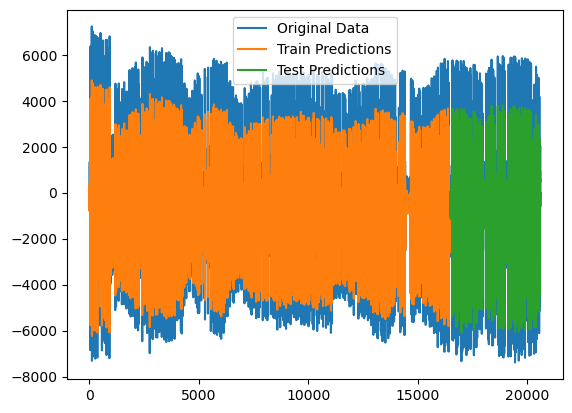

In [12]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(data)+2, :] = testPredict

plt.plot(scaler.inverse_transform(data), label='Original Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')

plt.legend()
plt.show()

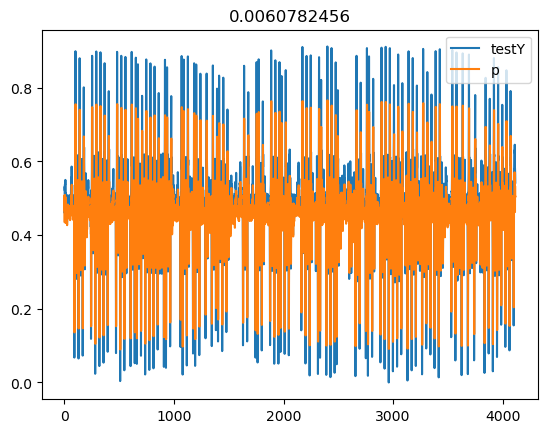

0.0060782456


In [13]:
plt.plot(y_test)
plt.plot(p)
plt.legend(['testY', 'p'], loc='upper right')
plt.title(mean_squared_error(y_test, p))
# plt.savefig(datetime.datetime.now())
plt.show()
print(mean_squared_error(y_test, p))